In [ ]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('../')
from src.data_processor import DataProcessor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
engine = DataProcessor(raw_data='../data/raw', processed_data='../data/processed/')
engine.load_data()


df_trans = engine.df_trans
df_prod = engine.df_prod
df_cust = engine.df_cust

tables = [
    ("Transactions", engine.df_trans),
    ("Products", engine.df_prod),
    ("Customers", engine.df_cust)
]

print(f"{'Table':<15} | {'Rows':<12} | {'Cols':<5} | {'Nulls %':<8}")
print("-" * 70)

for name, df in tables:
    rows = len(df)
    cols = len(df.columns)
    memory = df.memory_usage(deep=True).sum() / 1024**2
    null_pct = (df.isnull().sum().sum() / (rows * cols)) * 100
    print(f"{name:<15} | {rows:<12,} | {cols:<5} | {null_pct:<8.2f}%")
    


Data loaded successfully.
Table           | Rows         | Cols  | Nulls % 
----------------------------------------------------------------------
Transactions    | 1,983,549    | 9     | 0.00    %
Products        | 16,064       | 10    | 3.87    %
Customers       | 29,691       | 4     | 0.00    %


In [19]:
print("\n--- TRANSACTIONS DETAIL ---")
trans_audit = pd.DataFrame({
    'Dtype': engine.df_trans.dtypes,
    'Missing': engine.df_trans.isnull().sum(),
    'Unique': [engine.df_trans[col].nunique() for col in engine.df_trans.columns],
    'First_Value': engine.df_trans.iloc[0].values
})
print(trans_audit)


--- TRANSACTIONS DETAIL ---
                    Dtype  Missing   Unique              First_Value
id                  int64        0  1983549                  9974157
order_id            int64        0   262204                  1303020
trade_account_id    int64        0    27374                   635887
item_number        object        0    13721                  5008210
shipped_dt         object        0   220858  2025-01-16 12:21:00.000
origin             object        0        3                 EXTERNAL
type               object        0        2                   SAMPLE
netrevenue        float64        0     4912                      0.0
quantity          float64        0      577                      1.0


In [20]:
print("\n--- PRODUCT MASTER DETAIL ---")
prod_audit = pd.DataFrame({
    'Dtype': engine.df_prod.dtypes,
    'Missing': engine.df_prod.isnull().sum(),
    'Unique': [engine.df_prod[col].nunique() for col in engine.df_prod.columns],
    'First_Value': engine.df_prod.iloc[0].values
})
print(prod_audit)


--- PRODUCT MASTER DETAIL ---
                  Dtype  Missing  Unique              First_Value
item_number      object        0   16064                    54962
price_usd       float64      252     249                    158.0
arrival_date     object        0     346  2007-09-01 00:00:00.000
category_name    object        0       2                  FABRICS
color_name       object        3    2073                    IVORY
classification   object       22      13                    WOVEN
subclass         object      214      17              PLAIN WOVEN
scale            object       93       8                    SOLID
color_family     object     2887      46            WHITE & IVORY
motif            object     2747      41                    SOLID


In [21]:
print("\n--- CUSTOMER MASTER DETAIL ---")
cust_audit = pd.DataFrame({
    'Dtype': engine.df_cust.dtypes,
    'Missing': engine.df_cust.isnull().sum(),
    'Unique': [engine.df_cust[col].nunique() for col in engine.df_cust.columns],
    'First_Value': engine.df_cust.iloc[0].values
})
print(cust_audit)


--- CUSTOMER MASTER DETAIL ---
                   Dtype  Missing  Unique     First_Value
trade_account_id   int64        0   29691          670576
business_type     object        0      10   Design Studio
created_at        object        0    3418      2017-09-19
region            object        0      16  TRI-STATE AREA


In [22]:
print("=== KEY INTEGRITY CHECK ===")

# 1. Product Key Match
t_items = set(engine.df_trans['item_number'].unique())
p_items = set(engine.df_prod['item_number'].unique())
orphan_items = t_items - p_items

print(f"Total Unique Items in Transactions: {len(t_items):,}")
print(f"Total Unique Items in Product Master: {len(p_items):,}")
print(f"❌ ORPHAN ITEMS: {len(orphan_items):,} (Items sold but not in the Product Master)")

# 2. Customer Key Match
t_custs = set(engine.df_trans['trade_account_id'].unique())
c_custs = set(engine.df_cust['trade_account_id'].unique())
orphan_custs = t_custs - c_custs

print(f"\nTotal Unique Customers in Transactions: {len(t_custs):,}")
print(f"Total Unique Customers in Customer Master: {len(c_custs):,}")
print(f"❌ ORPHAN CUSTOMERS: {len(orphan_custs):,} (Accounts in Trans but not in the Customer Master)")

=== KEY INTEGRITY CHECK ===
Total Unique Items in Transactions: 13,721
Total Unique Items in Product Master: 16,064
❌ ORPHAN ITEMS: 0 (Items sold but not in the Product Master)

Total Unique Customers in Transactions: 27,374
Total Unique Customers in Customer Master: 29,691
❌ ORPHAN CUSTOMERS: 0 (Accounts in Trans but not in the Customer Master)


In [30]:
# Check for leading/trailing spaces in Transactions
spaces_trans = engine.df_trans['item_number'].str.contains(r'^\s|\s$').sum()

# Check for leading/trailing spaces in Product Master
spaces_prod = engine.df_prod['item_number'].str.contains(r'^\s|\s$').sum()

print(f"Items with hidden spaces (Trans): {spaces_trans}")
print(f"Items with hidden spaces (Prod): {spaces_prod}")

# Check for Case Sensitivity (Are there lowercase letters?)
lower_trans = engine.df_trans['item_number'].str.contains(r'[a-z]').sum()
print(f"Items with lowercase letters: {lower_trans}")

Items with hidden spaces (Trans): 0
Items with hidden spaces (Prod): 0
Items with lowercase letters: 0


In [31]:
# Convert to Sets for Comparison
set_trans = set(engine.df_trans['item_number'].unique())
set_prod = set(engine.df_prod['item_number'].unique())

# Calculate Overlap
common = set_trans.intersection(set_prod)
only_in_trans = set_trans - set_prod
only_in_prod = set_prod - set_trans

print("=== ITEM NUMBER ALIGNMENT ===")
print(f"Total unique items in Transactions: {len(set_trans):,}")
print(f"Total unique items in Product Master: {len(set_prod):,}")
print(f"✅ Items that MATCH: {len(common):,}")
print(f"❌ Orphan Items (Sales with no Product info): {len(only_in_trans):,}")
print(f"⚠️ Unsold Inventory (Products with no Sales/Samples): {len(only_in_prod):,}")

# Calculate Match Percentage
match_rate = (len(common) / len(set_trans)) * 100
print(f"\nMatch Rate: {match_rate:.2f}%")

=== ITEM NUMBER ALIGNMENT ===
Total unique items in Transactions: 13,721
Total unique items in Product Master: 16,064
✅ Items that MATCH: 13,721
❌ Orphan Items (Sales with no Product info): 0
⚠️ Unsold Inventory (Products with no Sales/Samples): 2,343

Match Rate: 100.00%


In [24]:
engine.merge_data()
df = engine.df_master
print(f"Master Table Columns: {df.columns.tolist()}")

📦 Processed data found at ../data/processed/master_analytical_file.csv. Loading existing file...
✅ Loaded 1,983,549 records from disk.
Master Table Columns: ['id', 'order_id', 'trade_account_id', 'item_number', 'shipped_dt', 'origin', 'type', 'netrevenue', 'quantity', 'business_type', 'created_at', 'region', 'price_usd', 'arrival_date', 'category_name', 'color_name', 'classification', 'subclass', 'scale', 'color_family', 'motif']


In [25]:
df.head()

,id,order_id,trade_account_id,item_number,shipped_dt,origin,type,netrevenue,quantity,business_type,...,region,price_usd,arrival_date,category_name,color_name,classification,subclass,scale,color_family,motif
0,9974157,1303020,635887,5008210,2025-01-16 12:21:00.000,EXTERNAL,SAMPLE,0.0,1.0,Other,...,HEARTLAND,94.0,2016-09-05 00:00:00.000,WALLCOVERINGS,FOG,TEXTURE,PRINT,EXTRA LARGE,LIGHT NEUTRAL,PAISLEY
1,11033952,1420308,647987,5013651,2025-05-01 17:43:00.000,EXTERNAL,SAMPLE,0.0,2.0,At Home Decorators,...,MIDWEST,48.0,2022-03-07 00:00:00.000,WALLCOVERINGS,OFF BLACK,FLAT PAPER,PRINT,MEDIUM,LIGHT NEUTRAL,DOTS
2,10381241,1346080,653558,75683,2025-02-21 00:26:06.730,Showroom,SAMPLE,0.0,1.0,Design Studio,...,PACIFIC SOUTHWEST,118.0,2021-08-02 00:00:00.000,FABRICS,YELLOW,WOVEN,PLAIN WOVEN,SOLID,YELLOW,SOLID
3,9966140,1302139,689951,175160,2025-01-14 14:18:00.000,EXTERNAL,SAMPLE,0.0,1.0,Other,...,SOUTH,178.0,2012-08-15 00:00:00.000,FABRICS,TAN,PRINT,PRINTED,LARGE,LIGHT NEUTRAL,ANIMAL
4,11123734,1430077,725247,5010571,2025-05-12 12:45:41.000,EXTERNAL,PRODUCT,1160.0,20.0,Other,...,ROCKY MOUNTAINS,58.0,2020-02-03 00:00:00.000,WALLCOVERINGS,SMOKE,FLAT PAPER,PRINT,LARGE,LIGHT NEUTRAL,GEOMETRIC


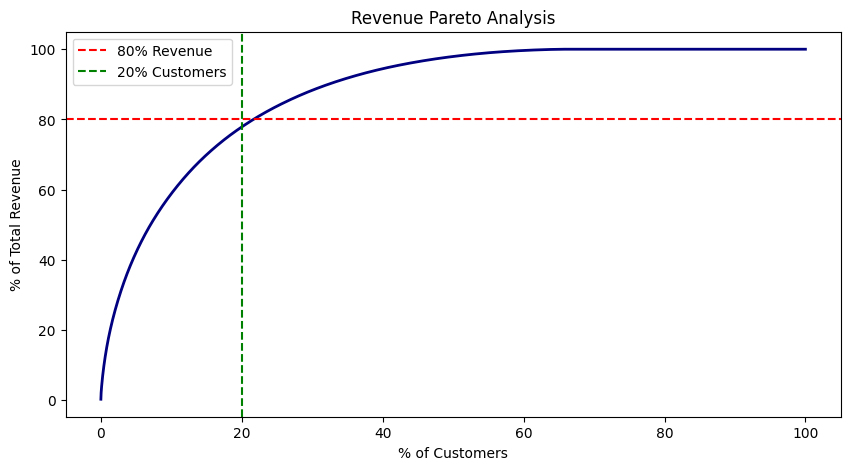

In [26]:
# Grouping by account to see total spend
customer_value = df.groupby('trade_account_id')['netrevenue'].sum().sort_values(ascending=False).reset_index()

# Calculated cumulative percentage
customer_value['cum_revenue_pct'] = 100 * (customer_value['netrevenue'].cumsum() / customer_value['netrevenue'].sum())
customer_value['cum_customer_pct'] = 100 * (customer_value.index + 1) / len(customer_value)


plt.figure(figsize=(10, 5))
plt.plot(customer_value['cum_customer_pct'], customer_value['cum_revenue_pct'], color='navy', lw=2)
plt.axhline(80, color='red', linestyle='--', label='80% Revenue')
plt.axvline(20, color='green', linestyle='--', label='20% Customers')
plt.title('Revenue Pareto Analysis')
plt.xlabel('% of Customers')
plt.ylabel('% of Total Revenue')
plt.legend()
plt.show()

In [27]:
# Count unique Account + Item combinations for Samples
total_samples = df[df['type'] == 'SAMPLE'].groupby(['trade_account_id', 'item_number']).size().shape[0]

# Count unique Account + Item combinations for Sales
total_sales = df[df['type'] == 'SALE'].groupby(['trade_account_id', 'item_number']).size().shape[0]

conversion_rate = (total_sales / total_samples) * 100
print(f"Global Sample-to-Sale Conversion Rate: {conversion_rate:.2f}%")

Global Sample-to-Sale Conversion Rate: 0.00%


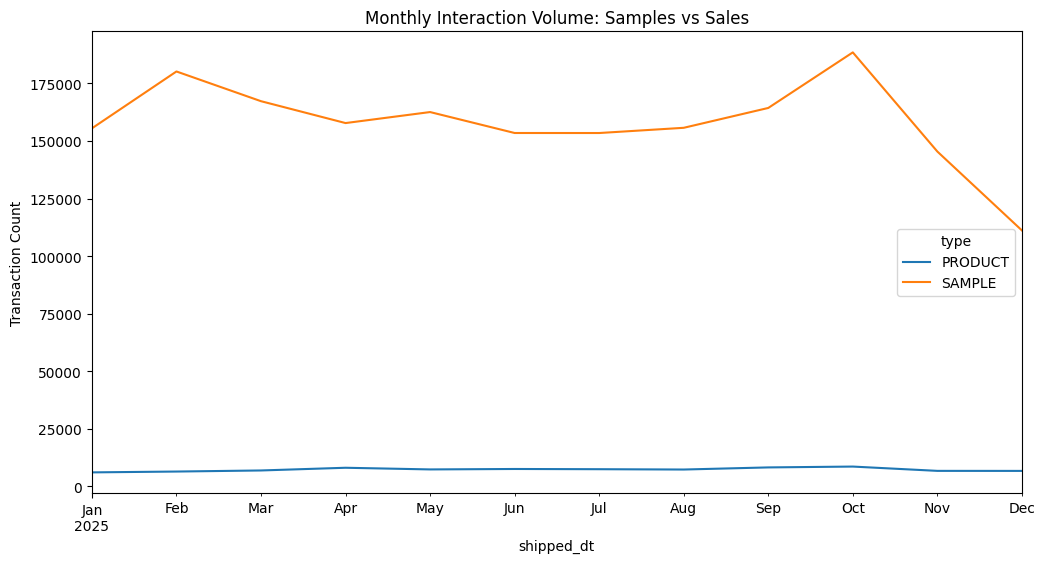

In [28]:
df['shipped_dt'] = pd.to_datetime(df['shipped_dt'])
df.set_index('shipped_dt').resample('ME')['type'].value_counts().unstack().plot(figsize=(12, 6))
plt.title('Monthly Interaction Volume: Samples vs Sales')
plt.ylabel('Transaction Count')
plt.show()



In [32]:
engine.df_trans['item_number'] = engine.df_trans['item_number'].astype(str).str.strip().str.upper()
engine.df_prod['item_number'] = engine.df_prod['item_number'].astype(str).str.strip().str.upper()

print("✅ Item Numbers sanitized (Stripped & Uppercased).")

✅ Item Numbers sanitized (Stripped & Uppercased).


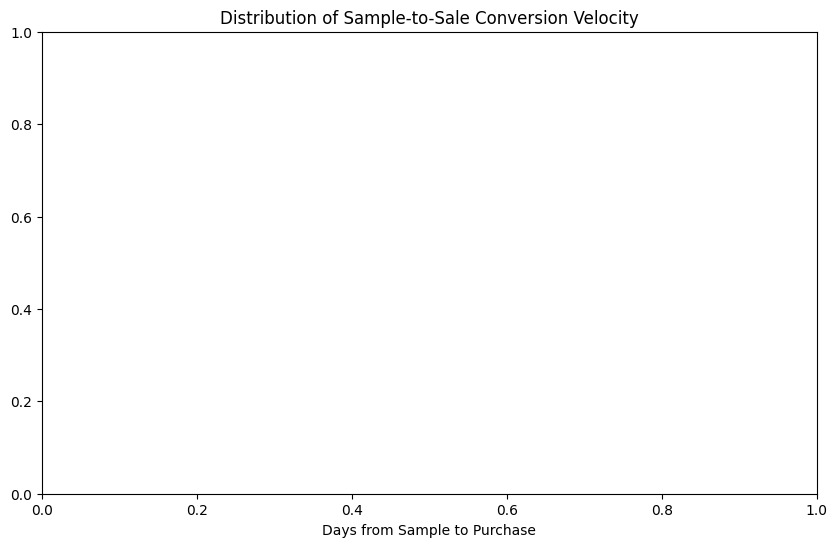

Median Days to Convert: nan


In [33]:
samples = df[df['type'] == 'SAMPLE'][['trade_account_id', 'item_number', 'shipped_dt']].copy()
samples = samples.rename(columns={'shipped_dt': 'sample_dt'})

sales = df[df['type'] == 'SALE'][['trade_account_id', 'item_number', 'shipped_dt', 'netrevenue']].copy()
sales = sales.rename(columns={'shipped_dt': 'sale_dt'})

# to find successful journeys
conversion_df = pd.merge(samples, sales, on=['trade_account_id', 'item_number'])

# filtering valid conversions
conversion_df = conversion_df[conversion_df['sale_dt'] >= conversion_df['sample_dt']].copy()

conversion_df['days_to_convert'] = (conversion_df['sale_dt'] - conversion_df['sample_dt']).dt.days

plt.figure(figsize=(10, 6))
sns.histplot(conversion_df['days_to_convert'], bins=50, kde=True, color='teal')
plt.title('Distribution of Sample-to-Sale Conversion Velocity')
plt.xlabel('Days from Sample to Purchase')
plt.show()

print(f"Median Days to Convert: {conversion_df['days_to_convert'].median()}")